In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import sys
import numpy as np
import matplotlib.pyplot as plt

try:
    import plotly.graph_objects as go
    import plotly.offline as pyo
    pyo.init_notebook_mode(connected=True)
    PLOTLY_AVAILABLE = True
except ImportError:
    PLOTLY_AVAILABLE = False
    print("plotlyがインストールされていません。'pip install plotly'でインストールしてください。")


from nets import *
from cfgs import *
from data import *
from trainer import *
from payment_utils import get_payment



In [2]:
%matplotlib inline
save_plot = False
plt.rcParams.update({'font.size': 10, 'axes.labelsize': 'x-large'})
D = 201

# v1, v2を[0, 1]の範囲で生成
x = np.linspace(0, 1.0, D)
# v3は固定値（cパラメータに合わせて、デフォルトは1.0）
v3_fixed = 1.0  # 必要に応じて変更可能

# 3財のテストデータを生成: [v1, v2, v3]
X_tst = np.stack([v.flatten() for v in np.meshgrid(x, x)], axis=-1)
# v3を固定値で追加
X_tst = np.concatenate([X_tst, np.full((X_tst.shape[0], 1), v3_fixed)], axis=-1)
print(X_tst.shape)

cfg = additive_1x3_constrained_config.cfg
cfg.test.batch_size = D
cfg.test.num_batches = int(X_tst.shape[0]/cfg.test.batch_size)
cfg.test.save_output = True


(40401, 3)


In [3]:
Net = constrained_additive_net.Net
Generator = constrained_3item_generator.Generator
Trainer = constrained_trainer.Trainer


In [4]:
net = Net(cfg, "test")
generator = Generator(cfg, 'test', X_tst)
m = Trainer(cfg, "test", net)
m.test(generator)


2025-11-12 20:12:42,393:INFO:TEST ALL-200000: t = 0.1441, Net_Loss: -0.364884, Revenue: 0.364884, Constraint_Viol: 0.000000, Const_Penalty: 0.000000, Const_Lag_Loss: 0.000000, w_constraint: 9.766611


In [5]:
alloc = np.load(os.path.join(cfg.dir_name, "alloc_tst_" + str(cfg.test.restore_iter) + ".npy")).reshape(D, D, 3)
pay = np.load(os.path.join(cfg.dir_name, "pay_tst_" + str(cfg.test.restore_iter) + ".npy")).reshape(D, D)


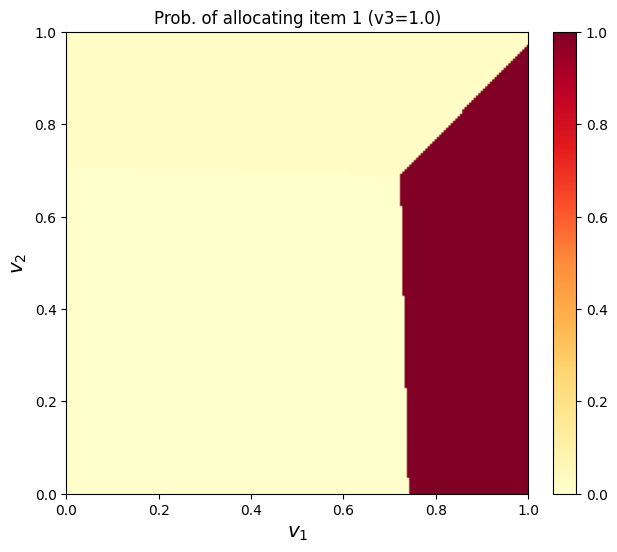

In [6]:
plt.rcParams.update({'font.size': 10, 'axes.labelsize': 'x-large'})
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(8, 6))

img = ax.imshow(alloc[::-1, :, 0], extent=[0, 1, 0, 1], vmin=0.0, vmax=1.0, cmap='YlOrRd')

ax.set_xlabel(r'$v_1$')
ax.set_ylabel(r'$v_2$')
plt.title(f'Prob. of allocating item 1 (v3={v3_fixed})')
_ = plt.colorbar(img, fraction=0.046, pad=0.04)

if save_plot:
    fig.set_size_inches(4, 3)
    plt.savefig(os.path.join(cfg.dir_name, 'alloc1.pdf'), bbox_inches='tight', pad_inches=0.05)


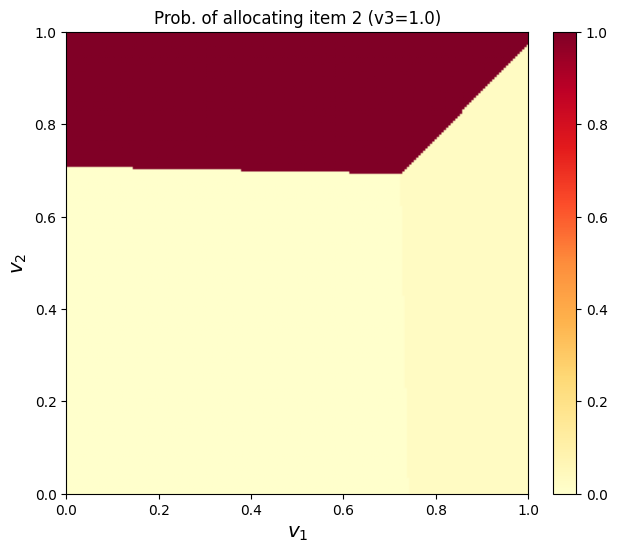

In [7]:
plt.rcParams.update({'font.size': 10, 'axes.labelsize': 'x-large'})
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(8, 6))

img = ax.imshow(alloc[::-1, :, 1], extent=[0, 1, 0, 1], vmin=0.0, vmax=1.0, cmap='YlOrRd')

ax.set_xlabel(r'$v_1$')
ax.set_ylabel(r'$v_2$')
plt.title(f'Prob. of allocating item 2 (v3={v3_fixed})')
_ = plt.colorbar(img, fraction=0.046, pad=0.04)

if save_plot:
    fig.set_size_inches(4, 3)
    plt.savefig(os.path.join(cfg.dir_name, 'alloc2.pdf'), bbox_inches='tight', pad_inches=0.05)


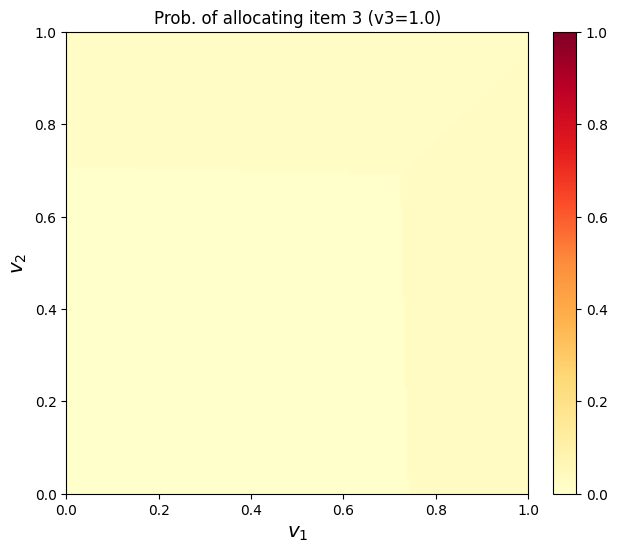

In [8]:
plt.rcParams.update({'font.size': 10, 'axes.labelsize': 'x-large'})
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(8, 6))

img = ax.imshow(alloc[::-1, :, 2], extent=[0, 1, 0, 1], vmin=0.0, vmax=1.0, cmap='YlOrRd')

ax.set_xlabel(r'$v_1$')
ax.set_ylabel(r'$v_2$')
plt.title(f'Prob. of allocating item 3 (v3={v3_fixed})')
_ = plt.colorbar(img, fraction=0.046, pad=0.04)

if save_plot:
    fig.set_size_inches(4, 3)
    plt.savefig(os.path.join(cfg.dir_name, 'alloc3.pdf'), bbox_inches='tight', pad_inches=0.05)


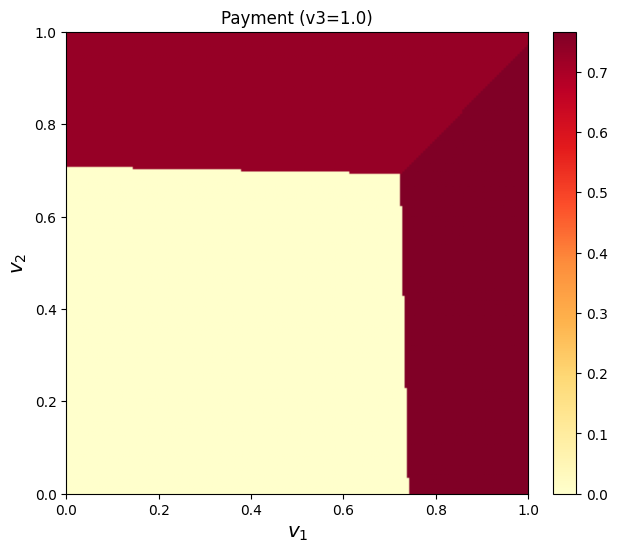

In [9]:
# インタラクティブなプロット（plotly使用）- マウスホバーで座標と値を表示
x_max = x[-1]  # Cell 1で定義されたxの最大値を使用
if PLOTLY_AVAILABLE:
    try:
        # データを準備
        pay_display = pay  # データは反転しない
        x_coords = np.linspace(0, x_max, D)
        y_coords = np.linspace(0, x_max, D)
        
        # plotlyのヒートマップを作成
        fig = go.Figure(data=go.Heatmap(
            z=pay_display,
            x=x_coords,
            y=y_coords,
            colorscale='YlOrRd',
            colorbar=dict(title="Payment"),
            hovertemplate='v₁=%{x:.3f}<br>v₂=%{y:.3f}<br>Payment=%{z:.6f}<extra></extra>',
            name=''
        ))
        
        fig.update_layout(
            title='Payment (Interactive - Hover to see values)',
            xaxis_title='v₁',
            yaxis_title='v₂',
            width=800,
            height=600
        )
        
        # HTMLファイルとして保存して表示（最も確実な方法）
        html_file = os.path.join(cfg.dir_name, 'pay_interactive.html')
        fig.write_html(html_file)
        print(f"インタラクティブなプロットを保存しました: {html_file}")
        print("ブラウザで開くと、マウスホバーで座標と値を表示できます。")
        
        # Jupyter Notebook内で表示を試みる
        try:
            from IPython.display import HTML, IFrame
            display(HTML(f'<iframe src="{{html_file}}" width="850" height="650"></iframe>'))
        except:
            try:
                from IPython.display import display, HTML
                display(HTML(f'<a href="{{html_file}}" target="_blank">インタラクティブなプロットを開く</a>'))
            except:
                pass
        
        if save_plot:
            try:
                fig.write_image(os.path.join(cfg.dir_name, 'pay.pdf'))
            except:
                pass  # write_imageが使えない場合はスキップ
    except Exception as e:
        print(f"plotlyの表示でエラーが発生しました: {e}")
        print("matplotlibのプロットにフォールバックします。")
        PLOTLY_AVAILABLE = False

if not PLOTLY_AVAILABLE:
    # plotlyが利用できない場合はmatplotlibを使用
    plt.rcParams.update({'font.size': 10, 'axes.labelsize': 'x-large'})
    fig, ax = plt.subplots(ncols = 1, nrows = 1, figsize = (8,6))
    
    # データを反転して表示（[::-1, :]の効果を考慮）
    pay_display = pay[::-1, :]
    
    img = ax.imshow(pay_display, extent=[0,x_max,0,x_max], cmap = 'YlOrRd')
                  
    ax.set_xlabel(r'$v_1$')
    ax.set_ylabel(r'$v_2$')
    plt.title('Payment')
    _ = plt.colorbar(img, fraction=0.046, pad=0.04)
    
    if save_plot:
        fig.set_size_inches(4, 3)
        plt.savefig(os.path.join(cfg.dir_name, 'pay.pdf'), bbox_inches = 'tight', pad_inches = 0.05)


In [10]:
# 制約違反の確認
# 下界: max(0, alloc1 + alloc2 - 1) <= alloc3
# 上界: alloc3 <= min(alloc1, alloc2)
lower_bound = np.maximum(0, alloc[:, :, 0] + alloc[:, :, 1] - 1)
upper_bound = np.minimum(alloc[:, :, 0], alloc[:, :, 1])
lower_violation = np.maximum(0, lower_bound - alloc[:, :, 2])
upper_violation = np.maximum(0, alloc[:, :, 2] - upper_bound)
constraint_violation = lower_violation + upper_violation

print("Constraint Violation Statistics:")
print(f"Min: {np.min(constraint_violation):.6f}")
print(f"Max: {np.max(constraint_violation):.6f}")
print(f"Mean: {np.mean(constraint_violation):.6f}")
print(f"Number of violations: {np.sum(constraint_violation > 1e-6)}")
print(f"Max violation: {np.max(constraint_violation):.6f}")


Constraint Violation Statistics:
Min: 0.000000
Max: 0.000000
Mean: 0.000000
Number of violations: 0
Max violation: 0.000000


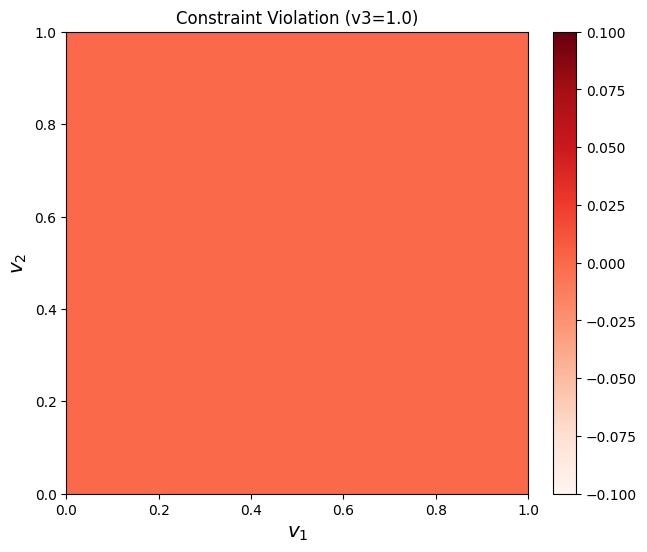

In [11]:
# 制約違反の可視化
plt.rcParams.update({'font.size': 10, 'axes.labelsize': 'x-large'})
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(8, 6))

img = ax.imshow(constraint_violation[::-1, :], extent=[0, 1, 0, 1], cmap='Reds')

ax.set_xlabel(r'$v_1$')
ax.set_ylabel(r'$v_2$')
plt.title(f'Constraint Violation (v3={v3_fixed})')
_ = plt.colorbar(img, fraction=0.046, pad=0.04)

if save_plot:
    fig.set_size_inches(4, 3)
    plt.savefig(os.path.join(cfg.dir_name, 'constraint_violation.pdf'), bbox_inches='tight', pad_inches=0.05)


In [12]:
# Payment statistics
v_max = x[-1]
print("Payment Statistics:")
print(f"Min: {np.min(pay):.6f}")
print(f"Max: {np.max(pay):.6f}")
print(f"Mean: {np.mean(pay):.6f}")
print(f"Median: {np.median(pay):.6f}")
print(f"Std: {np.std(pay):.6f}")
print(f"\nPayment at selected points:")
print(f"pay[0, 0] (v1=0, v2=0): {pay[0, 0]:.6f}")
print(f"pay[D//2, D//2] (v1={v_max/2:.1f}, v2={v_max/2:.1f}): {pay[D//2, D//2]:.6f}")
print(f"pay[-1, -1] (v1={v_max:.1f}, v2={v_max:.1f}): {pay[-1, -1]:.6f}")


Payment Statistics:
Min: 0.000000
Max: 0.766157
Mean: 0.364884
Median: 0.000000
Std: 0.373261

Payment at selected points:
pay[0, 0] (v1=0, v2=0): 0.000000
pay[D//2, D//2] (v1=0.5, v2=0.5): 0.000000
pay[-1, -1] (v1=1.0, v2=1.0): 0.729309
